In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torchvision.models as models
import torch.cuda.amp as amp
import os
import shutil
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import shutil
import numpy as np
import gc
import IPython
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

checkpoint_dir = "model_checkpoints"
if os.path.exists(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)
os.makedirs(checkpoint_dir, exist_ok=True)
torch.cuda.empty_cache()

In [2]:
def check_and_clear_cuda_memory():
    free_mem, total_mem = torch.cuda.mem_get_info()
    print(f"Before Clearing - Free memory: {free_mem / 1024**2:.2f} MB / {total_mem / 1024**2:.2f} MB")

    gc.collect()
    torch.cuda.empty_cache()
    IPython.display.clear_output(wait=True)  # Clear Jupyter output

    free_mem, total_mem = torch.cuda.mem_get_info()
    print(f"After Clearing - Free memory: {free_mem / 1024**2:.2f} MB / {total_mem / 1024**2:.2f} MB")

check_and_clear_cuda_memory()

After Clearing - Free memory: 11811.00 MB / 11968.00 MB


In [3]:
#seed = 42
#torch.manual_seed(seed)
#np.random.seed(seed)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [5]:
data_dir = "tiny-imagenet-200"

In [6]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3))
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
from PIL import Image
img_path = "tiny-imagenet-200/train/n01443537/images/n01443537_0.JPEG"
img = Image.open(img_path)
print(type(img))

<class 'PIL.JpegImagePlugin.JpegImageFile'>


In [8]:
#subset_size = 10000  # Adjust size , max is 100000
#train_dataset_full = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
#indices = np.random.choice(len(train_dataset_full), subset_size, replace=False)  # Fixed subset indices
#train_dataset = torch.utils.data.Subset(train_dataset_full, indices)
#train_dataset = torch.utils.data.Subset(train_dataset_full, range(subset_size))
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transforms)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

In [10]:
class BinaryActivation(nn.Module):
    #sign determiner
    def forward(self, x):
        return x.sign()

class BinaryConv2d(nn.Conv2d):
    #Weight binarizer
    def forward(self, x):
        bin_weight = self.weight.sign().to(x.device) #Binarizing to -1 or +1
        return F.conv2d(x, bin_weight, bias=None, stride=self.stride, padding=self.padding) #convolution 2d layer

class BinaryLinear(nn.Linear):
    def forward(self, x):
        bin_weight = self.weight.sign().to(x.device) #Binarizing to -1 or +1
        return F.linear(x, bin_weight, bias=None)

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.block = nn.Sequential(
            BinaryConv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.Hardtanh(min_val=-1, max_val=1),
            BinaryConv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            BinaryActivation()
        )

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                BinaryConv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        if self.downsample:
            residual = self.downsample(x)
        return self.block(x) + residual  

class BCNN(nn.Module):
    def __init__(self, num_classes=200):
        super(BCNN, self).__init__()

        self.initial = nn.Sequential(
            BinaryConv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            BinaryActivation()
        )

        #self.features = nn.Sequential(
        #    BasicBlock(64, 128, stride=2),
        #    BasicBlock(128, 256, stride=2),
        #    BasicBlock(256, 512, stride=2)
        #)

        self.layer1 = nn.Sequential(
            BasicBlock(64, 128, stride=2),
            BasicBlock(128, 128)
        )

        self.layer2 = nn.Sequential(
            BasicBlock(128, 256, stride=2),
            BasicBlock(256, 256)
        )

        self.layer3 = nn.Sequential(
            BasicBlock(256, 512, stride=2),
            BasicBlock(512, 512)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            BinaryActivation(),
            #nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.initial(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.adaptive_pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)

        return F.log_softmax(x, dim=1)

# Initialize model with Kaiming initialization
def init_weights(m):
    if isinstance(m, (BinaryConv2d, BinaryLinear)):
        nn.init.uniform_(m.weight.data, -1, 1)
        m.weight.data = m.weight.sign()

model = BCNN().to(device)
model.apply(init_weights) 
model

BCNN(
  (initial): Sequential(
    (0): BinaryConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): BinaryActivation()
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (block): Sequential(
        (0): BinaryConv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1, max_val=1)
        (3): BinaryConv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): BinaryActivation()
      )
      (downsample): Sequential(
        (0): BinaryConv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, trac

In [11]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.15)
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.95, weight_decay=1e-06)

In [12]:
def evaluate_model(model, data_loader, dataset_name="Testing"):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs, 1) #Accuracy computation
            total += labels.size(0) 
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'{dataset_name} Accuracy: {accuracy:.4f}')
    return accuracy

train_acc_list, test_acc_list, train_loss_list, test_loss_list, epoch_listings = [], [], [], [], []

In [13]:
num_epochs = 50
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.0001)
best_test_acc = 0.0
checkpoint_dir = "model_checkpoints"
scaler = amp.GradScaler()

os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(num_epochs):
    epoch_listings.append(epoch)
    model.train()
    running_loss_train = 0.0
    correct_train, total_train = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        with amp.autocast(): 
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()  # Scale loss before backward pass
        scaler.step(optimizer)  # Unscales gradients and updates optimizer
        scaler.update()  # Updates scaler for next iteration
        
        running_loss_train += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    scheduler.step()  # Step the scheduler

    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    train_accuracy = correct_train / total_train

    train_loss_list.append(epoch_loss_train)
    train_acc_list.append(train_accuracy)

    # Testing
    model.eval()
    running_loss_test = 0.0
    correct_test, total_test = 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss_test += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    epoch_loss_test = running_loss_test / len(test_loader.dataset)
    test_accuracy = correct_test / total_test

    test_loss_list.append(epoch_loss_test)
    test_acc_list.append(test_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss_train:.4f}, Test Loss: {epoch_loss_test:.4f}')
    print(f'Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}\n')

    
    del inputs, labels, outputs, loss
    gc.collect()
    torch.cuda.empty_cache()

    if test_accuracy > best_test_acc:
        best_test_acc = test_accuracy
        checkpoint_path = os.path.join(checkpoint_dir, 'best_model.pth')
        best_model = model
        print("Best model saved!")

print("Training complete.")

Epoch 1/50, Train Loss: 5.3773, Test Loss: 5.2944
Train Accuracy: 0.0066, Test Accuracy: 0.0052

Best model saved!
Epoch 2/50, Train Loss: 5.3039, Test Loss: 5.3292
Train Accuracy: 0.0112, Test Accuracy: 0.0051

Epoch 3/50, Train Loss: 5.2703, Test Loss: 5.3620
Train Accuracy: 0.0143, Test Accuracy: 0.0024

Epoch 4/50, Train Loss: 5.2543, Test Loss: 5.3798
Train Accuracy: 0.0163, Test Accuracy: 0.0021

Epoch 5/50, Train Loss: 5.2408, Test Loss: 5.3709
Train Accuracy: 0.0179, Test Accuracy: 0.0022

Epoch 6/50, Train Loss: 5.2317, Test Loss: 5.3809
Train Accuracy: 0.0181, Test Accuracy: 0.0022

Epoch 7/50, Train Loss: 5.2275, Test Loss: 5.3982
Train Accuracy: 0.0194, Test Accuracy: 0.0014

Epoch 8/50, Train Loss: 5.2230, Test Loss: 5.4053
Train Accuracy: 0.0194, Test Accuracy: 0.0017

Epoch 9/50, Train Loss: 5.2131, Test Loss: 5.4071
Train Accuracy: 0.0189, Test Accuracy: 0.0014

Epoch 10/50, Train Loss: 5.2073, Test Loss: 5.4180
Train Accuracy: 0.0212, Test Accuracy: 0.0024

Epoch 11/50

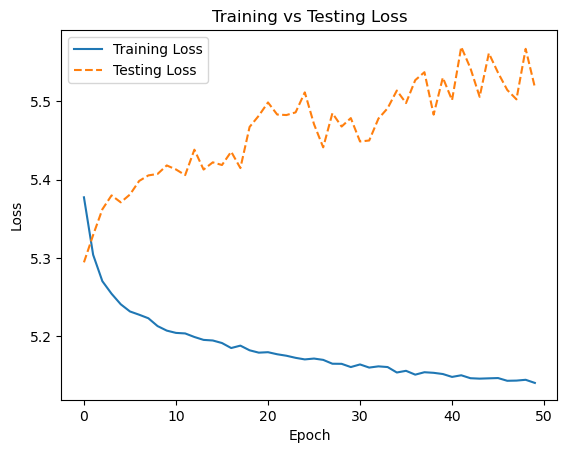

In [14]:
plt.plot(epoch_listings, train_loss_list, label='Training Loss')
plt.plot(epoch_listings, test_loss_list, label='Testing Loss', linestyle='dashed')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Testing Loss")
plt.show()

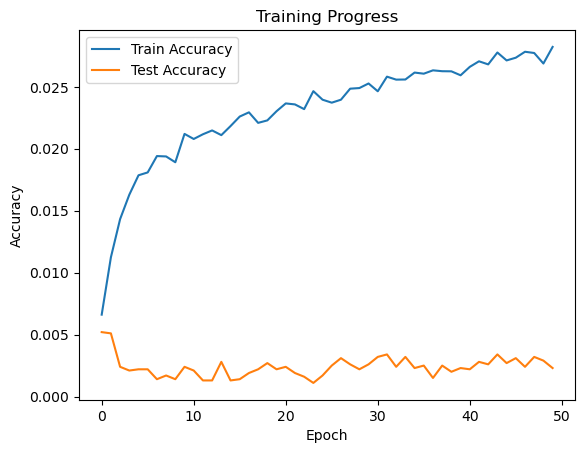

In [15]:
plt.plot(epoch_listings, train_acc_list, label="Train Accuracy")
plt.plot(epoch_listings, test_acc_list, label="Test Accuracy")
#plt.plot(epoch_listings, test_acc_list, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training Progress")
plt.show()